In [1]:
import numpy as np
from src.ShapeFunctions import EvaluateReferenceShapeFunctions
from src.GaussQuadrature import GaussQuadrature
from Element import ReferenceElementCoordinates
import matplotlib.pyplot as plt
import scipy.optimize
from itertools import chain

In [2]:
def HO_TRI(XeLIN,ElOrder):
    nedge = len(XeLIN[:,0])
    Xe = XeLIN.copy()
    # MAKE IT HIGH-ORDER:
    for i in range(nedge):
        # EDGE HIGH-ORDER NODES
        for k in range(1,ElOrder):
            HOnode = np.array([XeLIN[i,0]+((XeLIN[(i+1)%nedge,0]-XeLIN[i,0])/ElOrder)*k,XeLIN[i,1]+((XeLIN[(i+1)%nedge,1]-XeLIN[i,1])/ElOrder)*k])
            Xe = np.concatenate((Xe,HOnode.reshape((1,2))), axis=0)
    # INTERIOR HIGH-ORDER NODES:
    if ElOrder == 3:
        HOnode = np.array([np.mean(XeLIN[:,0]),np.mean(XeLIN[:,1])])
        Xe = np.concatenate((Xe,HOnode.reshape((1,2))), axis=0)
    return Xe, nedge

def HO_QUA(XeLIN,ElOrder):
    nedge = len(XeLIN[:,0])
    Xe = XeLIN.copy()
    for i in range(nedge):
        # EDGE HIGH-ORDER NODES
        for k in range(1,ElOrder):
            HOnode = np.array([XeLIN[i,0]+((XeLIN[(i+1)%nedge,0]-XeLIN[i,0])/ElOrder)*k,XeLIN[i,1]+((XeLIN[(i+1)%nedge,1]-XeLIN[i,1])/ElOrder)*k])
            Xe = np.concatenate((Xe,HOnode.reshape((1,2))), axis=0)
    # INTERIOR HIGH-ORDER NODES:
    if ElOrder == 2:
        HOnode = np.array([np.mean(XeLIN[:nedge,0]),np.mean(XeLIN[:nedge,1])])
        Xe = np.concatenate((Xe,HOnode.reshape((1,2))), axis=0)
    elif ElOrder == 3:
        for k in range(1,ElOrder):
            dx = (Xe[12-k,0]-Xe[5+k,0])/ElOrder
            dy = (Xe[12-k,1]-Xe[5+k,1])/ElOrder
            for j in range(1,ElOrder):
                if k == 1:
                    HOnode = Xe[11,:] - np.array([dx*j,dy*j])
                elif k == 2:
                    HOnode = Xe[7,:] + np.array([dx*j,dy*j])
                Xe = np.concatenate((Xe,HOnode.reshape((1,2))), axis=0)
    return Xe, nedge

def HO_InterfaceApprox(ElType,ElOrder,Xe,nedge,PHIe):
    # OBTAIN REFERENCE ELEMENT COORDINATES
    XIe = ReferenceElementCoordinates(ElType,ElOrder)

    # FIND POINTS ON INTERFACE USING ELEMENTAL INTERPOLATION
    #### INTERSECTION WITH EDGES
    XIeint = np.zeros([2,2])
    edgenodes = np.zeros([2,2], dtype=int)
    k = 0
    for i in range(nedge):  # Loop over elemental edges
        # Check for sign change along the edge
        inode = i
        jnode = (i + 1) % nedge
        if PHIe[inode] * PHIe[jnode] < 0:
            edgenodes[k,:] = [inode,jnode]
            if abs(XIe[jnode,0]-XIe[inode,0]) < 1e-6: # VERTICAL EDGE
                #### DEFINE CONSTRAINT PHI FUNCTION
                xi = XIe[inode,0]
                def PHIedge(eta):
                    X = np.array([xi,eta]).reshape((1,2))
                    N, foo, foo = EvaluateReferenceShapeFunctions(X, ElType, ElOrder, len(XIe[:,0]))
                    return N@PHIe
                #### FIND INTERSECTION POINT:
                Eta0 = 1/2  # INITIAL GUESS FOR ROOT SOLVER
                sol = scipy.optimize.root(PHIedge, Eta0)
                XIeint[k,:] = [xi, sol.x]
                k += 1
            else:
                def edgeconstraint(xi):
                    # FUNCTION DEFINING THE CONSTRAINT ON THE ELEMENTAL EDGE
                    m = (XIe[jnode,1]-XIe[inode,1])/(XIe[jnode,0]-XIe[inode,0])
                    eta = m*(xi-XIe[inode,0])+XIe[inode,1]
                    return eta
                def PHIedge(xi):
                    X = np.array([xi,edgeconstraint(xi)]).reshape((1,2))
                    N, foo, foo = EvaluateReferenceShapeFunctions(X, ElType, ElOrder, len(XIe[:,0]))
                    return N@PHIe
                #### FIND INTERSECTION POINT:
                Xi0 = 1/2  # INITIAL GUESS FOR ROOT SOLVER
                sol = scipy.optimize.root(PHIedge, Xi0)
                XIeint[k,:] = [sol.x, edgeconstraint(sol.x)]
                k += 1
            
    #### HIGH-ORDER INTERFACE NODES
    # IN THIS CASE, WITH USE THE REGULARITY OF THE REFERENCE TRIANGLE TO FIND THE NODES
    # LYING ON THE INTERFACE INSIDE THE ELEMENT. SIMILARLY TO THE INTERSECTION NODES ON THE
    # ELEMENTAL EDGES, EACH INTERIOR NODE CAN BE FOUND BY IMPOSING TWO CONDITIONS:
    #    - PHI = 0
    #    - NODE ON LINE DIVIDING THE 
    def PHI(X):
        N, foo, foo = EvaluateReferenceShapeFunctions(X, ElType, ElOrder, len(XIe[:,0]))
        return N@PHIe

    def fun(X):
        F = np.zeros([X.shape[0]])
        # SEPARATE GUESS VECTOR INTO INDIVIDUAL NODAL COORDINATES
        XHO = X.reshape((ElOrder-1,2)) 
        # PHI = 0 ON NODES
        for inode in range(ElOrder-1):
            F[inode] = PHI(XHO[inode,:].reshape((1,2)))
        # EQUAL DISTANCES BETWEEN INTERFACE NODES
        if ElOrder == 2:
            F[-1] = np.linalg.norm(XIeint[0,:]-X)-np.linalg.norm(XIeint[1,:]-X)
        if ElOrder == 3:
            #### FIRST INTERVAL
            F[ElOrder-1] = np.linalg.norm(XIeint[0,:]-XHO[0,:])-np.linalg.norm(XHO[0,:]-XHO[1,:])
            #### LAST INTERVAL
            F[-1] = np.linalg.norm(XIeint[1,:]-XHO[-1,:])-np.linalg.norm(XHO[-1,:]-XHO[-2,:])
        #### INTERIOR INTERVALS
        if ElOrder > 3:
            for intv in range(ElOrder-3):
                F[ElOrder+intv] = np.linalg.norm(XHO[intv+1,:]-XHO[intv+2,:]) - np.linalg.norm(XHO[intv+2,:]-XHO[intv+3,:])
        return F

    # PREPARE INITIAL GUESS
    X0 = np.zeros([(ElOrder-1)*2])
    for inode in range(1,ElOrder):
        X0[2*(inode-1):2*inode] = XIeint[0,:] + np.array([(XIeint[1,0]-XIeint[0,0]),(XIeint[1,1]-XIeint[0,1])])*inode/ElOrder
    X0 = X0.reshape((1,(ElOrder-1)*2))
    # COMPUTE HIGH-ORDER INTERFACE NODES COORDINATES
    sol = scipy.optimize.root(fun, X0)
    # STORE SOLUTION NODES
    XintINT = np.zeros([ElOrder-1,2])
    for inode in range(ElOrder-1):
        XintINT[inode,:] = np.reshape(sol.x, (ElOrder-1,2))[inode,:]

    # CONCATENATE INTERFACE NODES
    XIeintHO = np.concatenate((XIeint,XintINT),axis=0)
    
    # MAP BACK TO PHYSICAL SPACE
    #### EVALUATE REFERENCE SHAPE FUNCTIONS AT POINTS TO MAP (INTERFACE NODES)
    Nint, foo, foo = EvaluateReferenceShapeFunctions(XIeintHO, ElType, ElOrder, len(XIe[:,0]))
    XintHO = Nint@Xe
    
    return XintHO, XIe, XIeintHO, edgenodes

In [64]:
# SELECT ELEMENT
ElType = 2    # TYPE OF ELEMENT  -> 1 = TRIANGULAR;  2 = QUADRILATERAL
ElOrder = 3   # ELEMENTAL ORDER

# SELECT TESSELLATION CASE FOR QUADRILATERAL ELEMENT (2 SUBQUADRILATERAL OR 4 SUBTRIANGLES)
Nsub = 4

if ElType == 1: # TRIANGULAR ELEMENTS
    # COMPUTATIONAL DOMAIN
    Xmin = -1.5
    Xmax = 3.5
    Ymin = -2.5
    Ymax = 1.5
    XminREF = -0.2
    XmaxREF = 1.2
    YminREF = -0.2
    YmaxREF = 1.2
    Nx = 40
    Ny = 40
    xgrid = np.linspace(Xmin,Xmax,Nx)
    ygrid = np.linspace(Ymin,Ymax,Ny)
    X = np.zeros([Nx*Ny,2])
    for ix in range(Nx):
        for iy in range(Ny):
            X[ix*Nx+iy,:] = [xgrid[ix],ygrid[iy]]

    # LINEAR TRIANGLE
    XeLIN = np.array([[-1,1],
                [3,0.5],
                [0,-2]])

    Xe, nedge = HO_TRI(XeLIN,ElOrder)
        
    # INTERFACE = CIRCLE OR RADI sqrt(14) CENTERED AT (-2,+2)
    def f(r): 
        return (r[0]+2)**2+(r[1]-2)**2-14
    interf = np.zeros([Nx*Ny])
    for i in range(len(X[:,0])):
        interf[i] = f(X[i,:])
        
else:  # QUADRILATERAL ELEMENT
    # COMPUTATIONAL DOMAIN
    Xmin = -1.5
    Xmax = 3.5
    Ymin = -2.5
    Ymax = 1.5
    XminREF = -1.2
    XmaxREF = 1.2
    YminREF = -1.2
    YmaxREF = 1.2
    Nx = 40
    Ny = 40
    xgrid = np.linspace(Xmin,Xmax,Nx)
    ygrid = np.linspace(Ymin,Ymax,Ny)
    X = np.zeros([Nx*Ny,2])
    for ix in range(Nx):
        for iy in range(Ny):
            X[ix*Nx+iy,:] = [xgrid[ix],ygrid[iy]]

    # LINEAR QUADRILATERAL
    XeLIN = np.array([[-1,1],
                [2,1],
                [3,-1.5],
                [-0.5,-2]])
    
    Xe, nedge = HO_QUA(XeLIN,ElOrder)

    if Nsub == 2:
        # INTERFACE = CIRCLE OR RADI sqrt(12) CENTERED AT (+1,+3.2)
        def f(r): 
            return (r[0]-1)**2+(r[1]-3.2)**2-12
        interf = np.zeros([Nx*Ny])
        for i in range(len(X[:,0])):
            interf[i] = f(X[i,:])
    else:
        # INTERFACE = CIRCLE OR RADI sqrt(12) CENTERED AT (-2,+2)
        def f(r): 
            return (r[0]+2)**2+(r[1]-2)**2-12
        interf = np.zeros([Nx*Ny])
        for i in range(len(X[:,0])):
            interf[i] = f(X[i,:])
    
# GIVE LEVEL-SET VALUES TO THE NODES 
PHIe = np.zeros([len(Xe[:,0])])
for i in range(len(Xe[:,0])):
    PHIe[i] = f(Xe[i,:])

XintHO, XIe, XIeintHO, edgenodes = HO_InterfaceApprox(ElType,ElOrder,Xe,nedge,PHIe)


/tmp/ipykernel_1533858/3362212268.py:80: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  XIeint[k,:] = [sol.x, edgeconstraint(sol.x)]
/tmp/ipykernel_1533858/3362212268.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([xi,eta]).reshape((1,2))
/tmp/ipykernel_1533858/3362212268.py:65: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise th

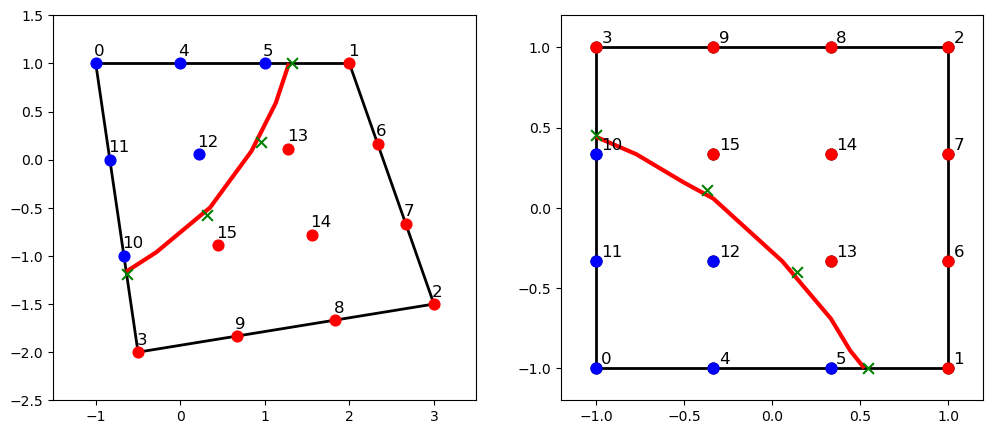

In [65]:
# REPRESENTING LEVEL-SET USING ONLY NODAL VALUES
fig, axs = plt.subplots(1, 2, figsize=(12,5))
#### LEFT PLOT: PHYSICAL SPACE
# PLOT ELEMENT EDGES
for iedge in range(nedge):
    axs[0].plot([Xe[iedge,0],Xe[int((iedge+1)%nedge),0]],[Xe[iedge,1],Xe[int((iedge+1)%nedge),1]], color='k', linewidth=2)
# PLOT NODES WITH NEGATIVE OR POSITIVE LEVEL-SET VALUES
for inode in range(len(Xe[:,0])):
    if PHIe[inode] < 0:
        cl = 'blue'
    else:
        cl = 'red'
    axs[0].scatter(Xe[inode,0],Xe[inode,1],s=60,color=cl,zorder=7)
for inode in range(len(Xe[:,0])):
    axs[0].text(Xe[inode,0]-0.02,Xe[inode,1]+0.08,str(inode),fontsize=12)
# PLOT INTERFACE
axs[0].tricontour(Xe[:,0],Xe[:,1],PHIe,levels=[0],colors='red', linewidths=3)
# PLOT INTERSECTION POINTS
axs[0].scatter(XintHO[:,0],XintHO[:,1],s=60,marker='x',color='green',zorder=7)
axs[0].set_ylim([Ymin,Ymax])
axs[0].set_xlim([Xmin,Xmax])

#### RIGHT PLOT: REFERENCE SPACE
# PLOT ELEMENT EDGES
for iedge in range(nedge):
    axs[1].plot([XIe[iedge,0],XIe[int((iedge+1)%nedge),0]],[XIe[iedge,1],XIe[int((iedge+1)%nedge),1]], color='k', linewidth=2)
for inode in range(len(XIe[:,0])):
    axs[1].scatter(XIe[inode,0],XIe[inode,1],s=60,color='k',zorder=7)
# PLOT NODES WITH NEGATIVE OR POSITIVE LEVEL-SET VALUES
for inode in range(len(XIe[:,0])):
    if PHIe[inode] < 0:
        cl = 'blue'
    else:
        cl = 'red'
    axs[1].scatter(XIe[inode,0],XIe[inode,1],s=60,color=cl,zorder=7)
for inode in range(len(XIe[:,0])):
    axs[1].text(XIe[inode,0]+0.03,XIe[inode,1]+0.03,str(inode),fontsize=12)
# PLOT INTERFACE
axs[1].tricontour(XIe[:,0],XIe[:,1],PHIe,levels=[0],colors='red', linewidths=3)
# PLOT INTERSECTION POINTS
axs[1].scatter(XIeintHO[:,0],XIeintHO[:,1],s=60,marker='x',color='green',zorder=7)
axs[1].set_ylim([YminREF,YmaxREF])
axs[1].set_xlim([XminREF,XmaxREF])
plt.show()

[0, array([2, 3]), 1]
[0, 2, 3, 1]


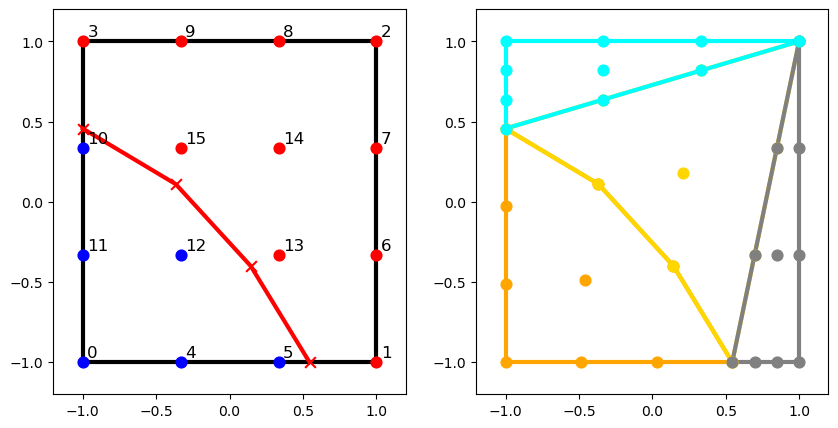

In [71]:
def HO_TRI_interf(XeLIN,ElOrder,XintHO,interfedge):
    nedge = len(XeLIN[:,0])
    XeHO = XeLIN.copy()
    # MAKE IT HIGH-ORDER:
    for iedge in range(nedge):
        inode = iedge
        jnode = (iedge+1)%nedge
        # EDGE HIGH-ORDER NODES
        if interfedge == iedge:
            XeHO = np.concatenate((XeHO,XintHO[2:,:]), axis=0)
        else:
            for k in range(1,ElOrder):
                HOnode = np.array([XeLIN[inode,0]+((XeLIN[jnode,0]-XeLIN[inode,0])/ElOrder)*k,XeLIN[inode,1]+((XeLIN[jnode,1]-XeLIN[inode,1])/ElOrder)*k])
                XeHO = np.concatenate((XeHO,HOnode.reshape((1,2))), axis=0)
    # INTERIOR HIGH-ORDER NODES:
    if ElOrder == 3:
        HOnode = np.array([np.mean(XeHO[:,0]),np.mean(XeHO[:,1])])
        XeHO = np.concatenate((XeHO,HOnode.reshape((1,2))), axis=0)
    return XeHO


def HO_QUA_interf(XeLIN,ElOrder,XintHO,interfedge):
    nedge = len(XeLIN[:,0])
    XeHO = XeLIN.copy()
    for iedge in range(nedge):
        inode = iedge
        jnode = (iedge+1)%nedge
        # EDGE HIGH-ORDER NODES
        if interfedge == iedge:
            XeHO = np.concatenate((XeHO,XintHO[2:,:]), axis=0)
        else:
            for k in range(1,ElOrder):
                HOnode = np.array([XeLIN[inode,0]+((XeLIN[jnode,0]-XeLIN[inode,0])/ElOrder)*k,XeLIN[inode,1]+((XeLIN[jnode,1]-XeLIN[inode,1])/ElOrder)*k])
                XeHO = np.concatenate((XeHO,HOnode.reshape((1,2))), axis=0)
    # INTERIOR HIGH-ORDER NODES:
    if ElOrder == 2:
        HOnode = np.array([np.mean(XeHO[:,0]),np.mean(XeHO[:,1])])
        XeHO = np.concatenate((XeHO,HOnode.reshape((1,2))), axis=0)
    elif ElOrder == 3:
        for k in range(1,ElOrder):
            dx = (XeHO[12-k,0]-XeHO[5+k,0])/ElOrder
            dy = (XeHO[12-k,1]-XeHO[5+k,1])/ElOrder
            for j in range(1,ElOrder):
                if k == 1:
                    HOnode = XeHO[11,:] - np.array([dx*j,dy*j])
                elif k == 2:
                    HOnode = XeHO[7,:] + np.array([dx*j,dy*j])
                XeHO = np.concatenate((XeHO,HOnode.reshape((1,2))), axis=0)
    return XeHO


def HO_ReferenceElementTessellation(ElType,ElOrder,XIeintHO,edgenodes):
    """ This function performs the TESSELLATION of a HIGH-ORDER element with nodal coordinates Xe and interface nodal coordinates XintHO"""
            
    # FIRST WE NEED TO DETERMINE WHICH IS THE VERTEX COMMON TO BOTH EDGES INTERSECTING WITH THE INTERFACE
    # AND ORGANISE THE NODAL MATRIX ACCORDINGLY SO THAT
    #       - THE FIRST ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH IS SHARED BY BOTH EDGES INTERSECTING THE INTERFACE 
    #       - THE SECOND ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH DEFINES THE EDGE ON WHICH THE FIRST INTERSECTION POINT IS LOCATED
    #       - THE THIRD ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH DEFINES THE EDGE ON WHICH THE SECOND INTERSECTION POINT IS LOCATED
    # HOWEVER, WHEN LOOKING FOR THE LINEAR APPROXIMATION OF THE PHYSICAL INTERFACE THIS PROCESS IS ALREADY DONE, THEREFORE WE CAN SKIP IT. 
    # IF INPUT Xemod IS PROVIDED, THE TESSELLATION IS DONE ACCORDINGLY TO MODIFIED NODAL MATRIX Xemod WHICH IS ASSUMED TO HAS THE PREVIOUSLY DESCRIBED STRUCTURE.
    # IF NOT, THE COMMON NODE IS DETERMINED (THIS IS THE CASE FOR INSTANCE WHEN THE REFERENCE ELEMENT IS TESSELLATED).

    XIeLIN = ReferenceElementCoordinates(ElType,1)

    if ElType == 1:  # TRIANGULAR ELEMENT
        Nsub = 3
        nedgesub = 3
        SubElType = 1
        distance = np.zeros([2])
        edgenode = np.zeros([2],dtype=int)
        commonnode = (set(edgenodes[0,:])&set(edgenodes[1,:])).pop() # COMMON NODE TO INTERSECTED EDGES
        # LOOK FOR NODE ON EDGE WHERE INTERSECTION POINT LIES BUT OTHER THAN COMMON NODE AND COMPUTE DISTANCE
        for i in range(2):
            edgenodeset = set(edgenodes[i,:])
            edgenodeset.remove(commonnode)
            edgenode[i] = edgenodeset.pop()
            distance[i] = np.linalg.norm(XIeintHO[i,:]-XIeLIN[edgenode[i],:])
        
        XIeTESSLIN = list()
        interfedge = [1,1,-1]
        XIeTESSLIN.append(np.concatenate((XIeLIN[int(commonnode),:].reshape((1,2)),XIeintHO[:2,:]),axis=0))
        if distance[0] < distance[1]:
            XIeTESSLIN.append(np.concatenate((XIeLIN[edgenode[1],:].reshape((1,2)),XIeintHO[:2,:]),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeLIN[[edgenode[0],edgenode[1]],:],XIeintHO[0,:].reshape((1,2))),axis=0))
        else:
            XIeTESSLIN.append(np.concatenate((XIeLIN[edgenode[0],:].reshape((1,2)),XIeintHO[:2,:]),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeLIN[[edgenode[1],edgenode[0]],:],XIeintHO[1,:].reshape((1,2))),axis=0))
        
        # TURN LINEAR SUBELEMENTS INTO HIGH-ORDER SUBELEMENTS
        XIeTESSHO = list()
        for isub in range(Nsub):
            XIeHO = HO_TRI_interf(XIeTESSLIN[isub],ElOrder,XIeintHO,interfedge[isub])
            XIeTESSHO.append(XIeHO)
            
        
    elif ElType == 2:  # QUADRILATERAL ELEMENT
        # LOOK FOR TESSELLATION CONFIGURATION BY USING SIGN OF prod(LSe)
                #  -> IF prod(LSe) > 0, THEN CUT SPLITS PARENT QUADRILATERAL ELEMENT INTO 2 CHILD QUADRILATERAL ELEMENTS
                #  -> IF prod(LSe) < 0, THEN CUT SPLITS PARENT QUADRILATERAL ELEMENT INTO PENTAGON AND TRIANGLE -> PENTAGON IS SUBDIVIDED INTO 3 SUBTRIANGLES
        if np.prod(PHIe[:nedge]) > 0:  # 2 SUBQUADRILATERALS
            Nsub = 2
            nedgesub = 4
            SubElType = 2
        
            interfedge = [1,1]
            XIeTESSLIN = list()
            XIeTESSLIN.append(np.concatenate((XIeLIN[edgenodes[0,0],:].reshape((1,2)),XIeintHO[:2,:],XIeLIN[edgenodes[1,1],:].reshape((1,2))),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeLIN[edgenodes[0,1],:].reshape((1,2)),XIeintHO[:2,:],XIeLIN[edgenodes[1,0],:].reshape((1,2))),axis=0))
            
            # TURN LINEAR TRIANGULAR SUBELEMENTS INTO HIGH-ORDER TRIANGULAR SUBELEMENTS
            XIeTESSHO = list()
            for isub in range(Nsub):
                XIeHO = HO_QUA_interf(XIeTESSLIN[isub],ElOrder,XIeintHO,interfedge[isub])
                XIeTESSHO.append(XIeHO)
            
        else:  # 4 SUBTRIANGLES
            Nsub = 4
            nedgesub = 3
            SubElType = 1
            # LOOK FOR COMMON NODE
            edgenode = np.zeros([2],dtype=int)
            distance = np.zeros([2])
            commonnode = (set(edgenodes[0,:])&set(edgenodes[1,:])).pop()
            # LOOK FOR NODE ON EDGE WHERE INTERSECTION POINT LIES BUT OTHER THAN COMMON NODE
            for i in range(2):
                edgenodeset = set(edgenodes[i,:])
                edgenodeset.remove(commonnode)
                edgenode[i] = edgenodeset.pop()
            # LOOK FOR OPPOSITE NODE
            for i in range(4):  # LOOP OVER VERTEX
                if np.isin(edgenodes, i).any():  # CHECK IF VERTEX IS PART OF THE EDGES ON WHICH THE INTERSECTION POINTS LIE
                    pass
                else:
                    oppositenode = i
                    
            XIeTESSLIN = list()
            interfedge = [1,1,-1,-1]
            XIeTESSLIN.append(np.concatenate((XIeLIN[int(commonnode),:].reshape((1,2)),XIeintHO[:2,:]),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeLIN[oppositenode,:].reshape((1,2)),XIeintHO[:2,:]),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeintHO[0,:].reshape((1,2)),XIeLIN[[edgenode[0],oppositenode],:]),axis=0))
            XIeTESSLIN.append(np.concatenate((XIeintHO[1,:].reshape((1,2)),XIeLIN[[edgenode[1],oppositenode],:]),axis=0))
            
            # TURN LINEAR TRIANGULAR SUBELEMENTS INTO HIGH-ORDER TRIANGULAR SUBELEMENTS
            XIeTESSHO = list()
            for isub in range(Nsub):
                XIeHO = HO_TRI_interf(XIeTESSLIN[isub],ElOrder,XIeintHO,interfedge[isub])
                XIeTESSHO.append(XIeHO)
            
    return Nsub, SubElType, nedgesub, XIeTESSHO, interfedge

# TESSELLATE REFERENCE ELEMENT
Nsub, SubElType, nedgesub, XIeTESSHO, interfedge = HO_ReferenceElementTessellation(ElType,ElOrder,XIeintHO,edgenodes)

# REPRESENTATION
colorlist = ['orange','gold','grey','cyan']
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# LEFT PLOT: PARENT ELEMENT
axs[0].set_ylim([YminREF,YmaxREF])
axs[0].set_xlim([XminREF,XmaxREF])
# PLOT ELEMENT EDGES
for iedge in range(nedge):
    axs[0].plot([XIe[iedge,0],XIe[int((iedge+1)%nedge),0]],[XIe[iedge,1],XIe[int((iedge+1)%nedge),1]], color='k', linewidth=3)
# PLOT NODES WITH NEGATIVE OR POSITIVE LEVEL-SET VALUES
for inode in range(len(XIe[:,0])):
    if PHIe[inode] < 0:
        cl = 'blue'
    else:
        cl = 'red'
    axs[0].scatter(XIe[inode,0],XIe[inode,1],s=60,color=cl,zorder=7)
for inode in range(len(XIe[:,0])):
    axs[0].text(XIe[inode,0]+0.03,XIe[inode,1]+0.03,str(inode),fontsize=12)
# PLOT INTERFACE APPROX
lnods = [0,np.arange(2,ElOrder+1),1]
lnods = list(chain.from_iterable([x] if not isinstance(x, np.ndarray) else x for x in lnods))
axs[0].plot(XIeintHO[lnods,0],XIeintHO[lnods,1],color='red',linewidth=3)
# PLOT INTERSECTION POINTS
axs[0].scatter(XIeintHO[:,0],XIeintHO[:,1],s=60,marker='x',color='red',zorder=7)

# RIGHT PLOT: HIGH-ORDER SUBELEMENTS
axs[1].set_ylim([YminREF,YmaxREF])
axs[1].set_xlim([XminREF,XmaxREF])
for isub in range(Nsub):
    XIesub = XIeTESSHO[isub]
    # PLOT SUBELEMENT EDGES
    for iedge in range(nedgesub):
        inode = iedge
        jnode = int((iedge+1)%nedgesub)
        if iedge == interfedge[isub]:
            inodeHO = nedgesub+(ElOrder-1)*inode
            xcoords = [XIesub[inode,0],XIesub[inodeHO:inodeHO+(ElOrder-1),0],XIesub[jnode,0]]
            xcoords = list(chain.from_iterable([x] if not isinstance(x, np.ndarray) else x for x in xcoords))
            ycoords = [XIesub[inode,1],XIesub[inodeHO:inodeHO+(ElOrder-1),1],XIesub[jnode,1]]
            ycoords = list(chain.from_iterable([y] if not isinstance(y, np.ndarray) else y for y in ycoords))
            axs[1].plot(xcoords,ycoords, color=colorlist[isub], linewidth=3)
        else:
            axs[1].plot([XIesub[inode,0],XIesub[jnode,0]],[XIesub[inode,1],XIesub[jnode,1]], color=colorlist[isub], linewidth=3)
    axs[1].scatter(XIesub[:,0],XIesub[:,1],s=60,color=colorlist[isub],zorder=7)
plt.show()


In [67]:
##### COMPUTE MODIFIED QUADRATURES (2D) FOR EACH SUBELEMENT 
# OBTAIN STANDARD GAUSS QUADRATURE
XIg2Dstand, Wg2Dstand, Ng2Dstand = GaussQuadrature(ElType,2) 
XIg2Dstand_sub, Wg2Dstand_sub, Ng2Dstand_sub = GaussQuadrature(SubElType,2) 
# EVALUATE SUBELEMENTAL REFERENCE SHAPE FUNCTIONS 
N2Dstand, foo, foo = EvaluateReferenceShapeFunctions(XIg2Dstand_sub, SubElType, ElOrder, len(XIeTESSHO[0][:,0]))
# MAP STANDARD GAUSS QUADRATURE TO SUBELEMENTS
XIg2D = list()
for isub in range(Nsub):
    XIg2D.append(N2Dstand @ XIeTESSHO[isub])
    
##### COMPUTE MODIFIED QUADRATURES (1D) FOR EACH SEGMENT IN APPROXIMATED INTERFACE
# OBTAIN STANDARD GAUSS QUADRATURE
XIg1Dstand, Wg1Dstand, Ng1Dstand = GaussQuadrature(0,2) 
# EVALUATE REFERENCE SHAPE FUNCTIONS 
N1Dstand, foo, foo = EvaluateReferenceShapeFunctions(XIg1Dstand, 0, 1, 2)
# MAP STANDARD GAUSS QUADRATURE TO INTERFACE APPROXIMATION SEGMENTS
XIg1D = list()
for isegm in range(ElOrder):
    XIg1D.append(N1Dstand @ XIeintHO[lnods[isegm:isegm+2],:])


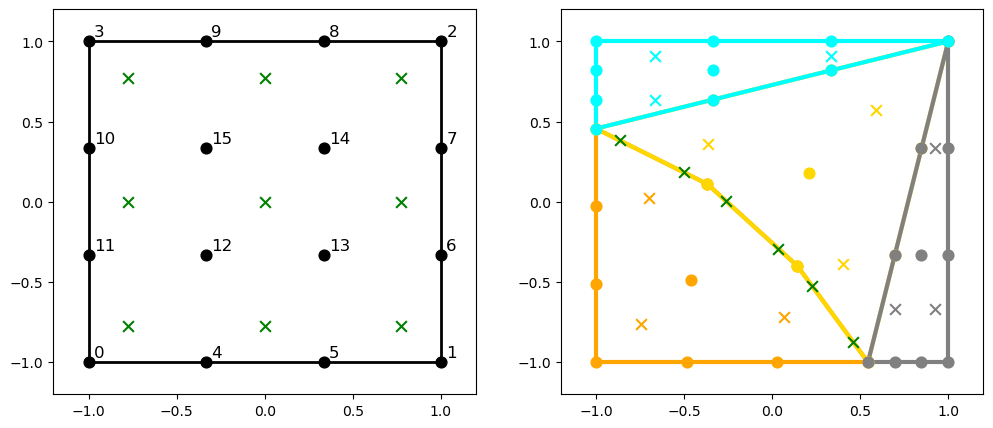

In [96]:
# REPRESENTATION
fig, axs = plt.subplots(1, 2, figsize=(12,5))
#### LEFT PLOT: REFERENCE PARENT ELEMENT
# PLOT ELEMENT EDGES
for iedge in range(nedge):
    axs[0].plot([XIe[iedge,0],XIe[int((iedge+1)%nedge),0]],[XIe[iedge,1],XIe[int((iedge+1)%nedge),1]], color='k', linewidth=2)
axs[0].scatter(XIe[:,0],XIe[:,1],s=60,color='k',zorder=7)
for inode in range(len(XIe[:,0])):
    axs[0].text(XIe[inode,0]+0.03,XIe[inode,1]+0.03,str(inode),fontsize=12)
# PLOT STANDARD QUADRATURE
axs[0].scatter(XIg2Dstand[:,0],XIg2Dstand[:,1],s=60,marker='x',color='green',zorder=7)
axs[0].set_ylim([YminREF,YmaxREF])
axs[0].set_xlim([XminREF,XmaxREF])

#### RIGHT PLOT: REFERENCE HIGH-ORDER SUBELEMENTS
axs[1].set_ylim([YminREF,YmaxREF])
axs[1].set_xlim([XminREF,XmaxREF])
## SUBELEMENTS REPRESENTATION
for isub in range(Nsub):
    XIesub = XIeTESSHO[isub]
    XIg2Dsub = XIg2D[isub]
    # PLOT SUBELEMENT EDGES
    for iedge in range(nedgesub):
        inode = iedge
        jnode = int((iedge+1)%nedgesub)
        if iedge == interfedge[isub]:
            inodeHO = nedgesub+(ElOrder-1)*inode
            xcoords = [XIesub[inode,0],XIesub[inodeHO:inodeHO+(ElOrder-1),0],XIesub[jnode,0]]
            xcoords = list(chain.from_iterable([x] if not isinstance(x, np.ndarray) else x for x in xcoords))
            ycoords = [XIesub[inode,1],XIesub[inodeHO:inodeHO+(ElOrder-1),1],XIesub[jnode,1]]
            ycoords = list(chain.from_iterable([y] if not isinstance(y, np.ndarray) else y for y in ycoords))
            axs[1].plot(xcoords,ycoords, color=colorlist[isub], linewidth=3)
        else:
            axs[1].plot([XIesub[inode,0],XIesub[jnode,0]],[XIesub[inode,1],XIesub[jnode,1]], color=colorlist[isub], linewidth=3)
    axs[1].scatter(XIesub[:,0],XIesub[:,1],s=60,color=colorlist[isub],zorder=7)
    axs[1].scatter(XIg2Dsub[:,0],XIg2Dsub[:,1],s=60,marker='x',color=colorlist[isub],zorder=7)
    
## APPROXIMATED INTERFACE REPRESENTATION
for isegm in range(ElOrder):
    axs[1].scatter(XIg1D[isegm][:,0],XIg1D[isegm][:,1],s=60,marker='x',color='green',zorder=7)
    
plt.show()


In [75]:
# MAP TESSELLATION TO PHYSICAL SPACE
XeTESSHO = list()
Xg2D = list()
for isub in range(Nsub):
    ##### MAP TESSELLATION SUBELEMENTS NODAL COORDINATES 
    # EVALUATE ELEMENTAL REFERENCE SHAPE FUNCTIONS AT SUBELEMENTAL NODAL COORDINATES 
    N2D, foo, foo = EvaluateReferenceShapeFunctions(XIeTESSHO[isub], ElType, ElOrder, len(XIe[:,0]))
    # MAP SUBELEMENTAL NODAL COORDINATES TO PHYSICAL SPACE
    XeTESSHO.append(N2D @ Xe)
    ##### MAP 2D SUBELEMENTAL MODIFIED QUADRATURES 
    # EVALUATE REFERENCE SHAPE FUNCTIONS ON SUBELEMENTAL GAUSS INTEGRATION NODES
    N2Dsub, dNdxisub, dNdetasub = EvaluateReferenceShapeFunctions(XIg2D[isub], ElType, ElOrder, len(XIe[:,0]))
    # MAP SUBELEMENTAL GAUSS INTEGRATION NODES TO PHYSICAL SPACE
    Xg2D.append(N2Dsub @ Xe)

##### MAP 1D INTERFACE APPROXIMATION MODIFIED QUADRATURE
Xg1D = list()
for isegm in range(ElOrder):
    # EVALUATE REFERENCE SHAPE FUNCTIONS ON 1D MODIFIED QUADRATURE
    N1D, foo, foo = EvaluateReferenceShapeFunctions(XIg1D[isegm], ElType, ElOrder, len(XIe[:,0]))
    # MAP MODIFIED REFERENCE GAUSS QUADRATURE TO PHYSICAL SPACE
    Xg1D.append( N1D@Xe )

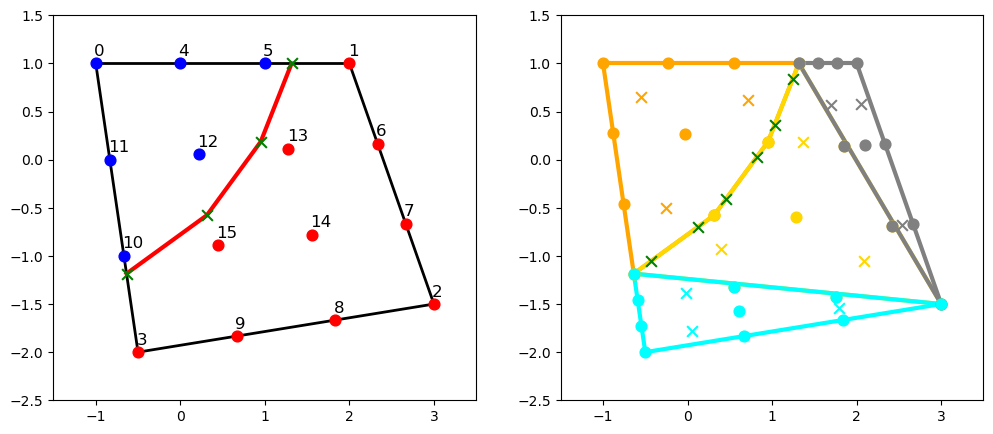

In [97]:
# REPRESENTATION
fig, axs = plt.subplots(1, 2, figsize=(12,5))
#### LEFT PLOT: REFERENCE SPACE
# PLOT ELEMENT EDGES
for iedge in range(nedge):
    axs[0].plot([Xe[iedge,0],Xe[int((iedge+1)%nedge),0]],[Xe[iedge,1],Xe[int((iedge+1)%nedge),1]], color='k', linewidth=2)
# PLOT NODES WITH NEGATIVE OR POSITIVE LEVEL-SET VALUES
for inode in range(len(Xe[:,0])):
    if PHIe[inode] < 0:
        cl = 'blue'
    else:
        cl = 'red'
    axs[0].scatter(Xe[inode,0],Xe[inode,1],s=60,color=cl,zorder=7)
for inode in range(len(Xe[:,0])):
    axs[0].text(Xe[inode,0]-0.02,Xe[inode,1]+0.08,str(inode),fontsize=12)
# PLOT INTERFACE APPROX
axs[0].plot(XintHO[lnods,0],XintHO[lnods,1],color='red',linewidth=3)
# PLOT INTERSECTION POINTS
axs[0].scatter(XintHO[:,0],XintHO[:,1],s=60,marker='x',color='green',zorder=7)
axs[0].set_ylim([Ymin,Ymax])
axs[0].set_xlim([Xmin,Xmax])

#### RIGHT SUBPLOT: PHYSICAL SPACE
# PLOT ELEMENT EDGES
axs[1].set_ylim([Ymin,Ymax])
axs[1].set_xlim([Xmin,Xmax])
## SUBELEMENTAL REPRESENTATION
for isub in range(Nsub):
    Xesub = XeTESSHO[isub]
    Xg2Dsub = Xg2D[isub]
    # PLOT SUBELEMENT EDGES
    for iedge in range(nedgesub):
        inode = iedge
        jnode = int((iedge+1)%nedgesub)
        if iedge == interfedge[isub]:
            inodeHO = nedgesub+(ElOrder-1)*inode
            xcoords = [Xesub[inode,0],Xesub[inodeHO:inodeHO+(ElOrder-1),0],Xesub[jnode,0]]
            xcoords = list(chain.from_iterable([x] if not isinstance(x, np.ndarray) else x for x in xcoords))
            ycoords = [Xesub[inode,1],Xesub[inodeHO:inodeHO+(ElOrder-1),1],Xesub[jnode,1]]
            ycoords = list(chain.from_iterable([y] if not isinstance(y, np.ndarray) else y for y in ycoords))
            axs[1].plot(xcoords,ycoords, color=colorlist[isub], linewidth=3)
        else:
            axs[1].plot([Xesub[inode,0],Xesub[jnode,0]],[Xesub[inode,1],Xesub[jnode,1]], color=colorlist[isub], linewidth=3)
    axs[1].scatter(Xesub[:,0],Xesub[:,1],s=60,color=colorlist[isub],zorder=7)
    axs[1].scatter(Xg2Dsub[:,0],Xg2Dsub[:,1],s=60,marker='x',color=colorlist[isub],zorder=7)

## APPROXIMATED INTERFACE REPRESENTATION
for isegm in range(ElOrder):
    axs[1].scatter(Xg1D[isegm][:,0],Xg1D[isegm][:,1],s=60,marker='x',color='green',zorder=7)

plt.show()
